### Automatic summarization of science publication texts, machine learning based.

#### Including:
- Text Preprocessing
- KeyWords extraction
- Syntactic Parsing. Part of speech tagging
- Word Embedding (text vectors). 
- Word2Vec Model Visualisation
- TF – IDF matrices 
- Search cosine similarity between documents
- Five different algorithms for construction of summaries: 
    improved "TextRank" from Gensim, usual TextRank, LSA, Kullback–Leibler, LexRank

In [1]:
# Word2Vec model (word embeddings).
from gensim.models import Word2Vec

# This summarizer is based on the improved "TextRank" algorithm, and uses "BM25 ranking function".
from gensim.summarization import summarize, keywords

# Four different algorithms: usual TextRank, LSA, Kullback–Leibler, LexRank.
from sumy.summarizers.text_rank import TextRankSummarizer as TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.summarizers.kl import KLSummarizer as KL
from sumy.summarizers.lex_rank import LexRankSummarizer as LRS

# Used for text preprocessing.
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

# ROUGE - set of metrics used for evaluating automatic summarization.
import sumy.evaluation.rouge as Rogue

# Using for search cosine similarity between documents - articles.
from sklearn.metrics.pairwise import cosine_similarity

# Term Frequency – Inverse Document Frequency (TF – IDF).
from sklearn.feature_extraction.text import TfidfVectorizer

# t-distributed Stochastic Neighbor Embedding.
from sklearn.manifold import TSNE

# Used for text preprocessing and part of speech tagging.
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

# Download NLTK corpuses.
nltk.download("stopwords")
nltk.download('wordnet')

import os
import string

# Used for data representation.
import pandas as pd
import numpy as np

# Used for visualisation.
import matplotlib.pyplot as plt
import pylab as pyl
from mpl_toolkits.mplot3d import axes3d

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kvoronaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kvoronaya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
PATH_TEST_SET = 'C:/Users/kvoronaya/texts_analysing_system/test_set_vkr/'

In [3]:
file_name_mapping = {}
test_set = []
count = 0

for file in os.listdir(PATH_TEST_SET):
    if file.endswith(".txt"):
        file_name_mapping[count] = file
        count += 1
        f = open(PATH_TEST_SET + file, 'r')
        for line in f:
            line = line.decode("ascii","ignore")
            # document should always contain only one line
            test_set.append(line)

print('***** File Name Mapping *****')           
for k, v in file_name_mapping.items():
    print('{}: "{}"'.format(k, v))

***** File Name Mapping *****
0: "Association of Hormonal Contraception With Depression.txt"
1: "Behavioral Interventions for Antipsychotic Medication Associated Obesity.txt"
2: "Care for Adolescents with Depression in Primary Care Settings.txt"
3: "Cigarette Smoking and the Onset and Persistence of Panic Attacks During Mid-Adulthood in the United States.txt"
4: "Efficacy of Topiramate in the Treatment of Crack Cocaine Dependence.txt"
5: "Efficacy, Acceptability, and Tolerability of Antipsychotics in Treatment-Resistant Schizophrenia.txt"
6: "Exaggerated Acquisition and Resistance to Extinction of Avoidance Behavior in Treated Heroin-Dependent Men.txt"
7: "Short-term Suicide Risk After Psychiatric Hospital Discharge.txt"
8: "Treatment Preferences of Psychotherapy Patients with Chronic PTSD.txt"
9: "Use of Acetaminophen (Paracetamol) During Pregnancy .txt"


#### -------------------------- Text Preprocessing ---------------------------------------------------------------------------------------------------------------------

In [4]:
def text_preprocessing(test_set):
    prepared_test_set = list()
    for document in test_set:
        
        # tokenization – process of converting a text into tokens
        tokens = word_tokenize(document)
        
        # remove stop-words
        filtered_doc_words = [word for word in tokens if word not in stopwords.words('english')]
        
        # lemmatization process - procedure of obtaining the root form of the word
        wordnet_lemmatizer = WordNetLemmatizer()
        lemmatization_words = []
        for word in filtered_doc_words:
            lemm_word = wordnet_lemmatizer.lemmatize(word)
            lemmatization_words.append(lemm_word)
        
        prepared_doc = ' '.join(lemmatization_words)
        prepared_test_set.append(prepared_doc)
        
    return prepared_test_set

prepared_test_set = text_preprocessing(test_set)    

#### -------------------------- KeyWords extraction ----------------------------------------------------------------------------

In [5]:
number_keywords = 10
keywords_test_set = {}
index = 0

for doc in prepared_test_set:
    extracted_keywords =  keywords(doc, words=number_keywords, scores=True, lemmatize=True)
    keywords_test_set[index] = extracted_keywords
    index += 1

dataframe = list()  
for value in keywords_test_set.values():
    dataframe.append(value)

In [6]:
KEYWORDS = pd.DataFrame(dataframe, columns=['KeyWord & Score']*10)
KEYWORDS

,KeyWord & Score,KeyWord & Score,KeyWord & Score,KeyWord & Score,KeyWord & Score,KeyWord & Score,KeyWord & Score,KeyWord & Score,KeyWord & Score,KeyWord & Score
0,"(user, [0.267216429183])","(contraceptive, [0.257075094941])","(use, [0.245066868162])","(woman, [0.212146079792])","(associated, [0.177051729335])","(psychiatric, [0.169170011267])","(diagnosis, [0.168346994999])","(hormonal, [0.163656483025])","(january, [0.144412153096])","(year, [0.141149162559])"
1,"(control, [0.234662902125])","(smi, [0.224329601417])","(medication, [0.166859435553])","(class, [0.166206461617])","(group, [0.166202166359])","(treatment, [0.164366642275])","(effective, [0.16394636219])","(interventions, [0.161796517003])","(knowledge, [0.158982657108])","(counseling, [0.157518926393])"
2,"(costs, [0.3320741284])","(care, [0.276727789845])","(depression, [0.25152355147])","(effective, [0.246144203219])","(adolescents, [0.245083075426])","(health, [0.224768702332])","(intervention, [0.20406019158])","(group, [0.173564242552])","(qalys, [0.14849737834])","(collaborative, [0.146138270538])"
3,"(smoking, [0.325133307891])","(year, [0.241450876136])","(attacks, [0.185775123445])","(onset, [0.184524269285])","(risk, [0.183135987694])","(data, [0.175294298524])","(wave, [0.167876710833])","(panic, [0.158807946924])","(based, [0.15588890665])","(united, [0.155520409927])"
4,"(cocaine, [0.371003971018])","(group, [0.313540014415])","(topiramate, [0.283979155483])","(subject, [0.251905802251])","(studied, [0.248619372311])","(use, [0.216307526629])","(treatment, [0.203472372092])","(placebo, [0.140252119317])","(week, [0.13265122596])","(control, [0.129466380513])"
5,"(clozapine, [0.299238648487])","(antipsychotic, [0.270985047024])","(effective, [0.249449074991])","(treatment, [0.234353855335])","(trials, [0.195890011285])","(schizophrenia, [0.193089950974])","(evidence, [0.155805473829])","(rcts, [0.155587895934])","(randomized, [0.147880608834])","(change, [0.146491841048])"
6,"(avoidance, [0.33637819377])","(opioid, [0.260168854614])","(behavioral, [0.250658044231])","(task, [0.183852159204])","(hiding, [0.171616781522])","(different, [0.170747799566])","(dependence, [0.163464685072])","(abnormal, [0.146285660347])","(aversive event, [0.14605990018])",None
7,"(disorder, [0.400835511967])","(suicide, [0.328866517918])","(inpatient, [0.244975362963])","(cohort, [0.22359309293])","(adult, [0.215556334549])","(year, [0.211287295335])","(discharge, [0.177299101596])","(diagnosis, [0.155841064908])","(hospital, [0.153777114842])","(death, [0.143028922545])"
8,"(preferences, [0.422235830408])","(patients, [0.370151609122])","(treatment, [0.331900856392])","(outcome, [0.251996545759])","(psychotherapy, [0.232550057254])","(ptsd, [0.196338779899])","(depressed, [0.146501862787])","(clinical, [0.138754563027])","(research, [0.131335451141])","(chronic, [0.123320049096])"
9,"(study, [0.318763258672])","(adhd, [0.288811247658])","(pregnancy, [0.271242939913])","(risk, [0.264390659747])","(acetaminophen, [0.224141572013])","(attention, [0.170819185708])","(use, [0.165406795656])","(offspring, [0.139080819912])","(infection, [0.137813464181])","(outcome, [0.136368161902])"


#### -------------------------- Syntactic Parsing. Part of speech tagging. ---------------------------------------------------------------------------------------

Universal Part-of-Speech Tagset:

CC: conjunction, coordinating

CD: numeral, cardinal

DT: determiner

IN: preposition or conjunction, subordinating

JJ: adjective or numeral, ordinal

JJR: adjective, comparative

JJS: adjective, superlative

LS: list item marker

MD: modal auxiliary

NN: noun, common, singular or mass

NNP: noun, proper, singular

NNS: noun, common, plural

PDT: pre-determiner

POS: genitive marker

PRP: pronoun, personal

RB: adverb

RBR: adverb, comparative

RBS: adverb, superlative

RP: particle

UH: interjection

VB: verb, base form

VBD: verb, past tense

VBG: verb, present participle or gerund

VBN: verb, past participle

VBP: verb, present tense, not 3rd person singular

VBZ: verb, present tense, 3rd person singular

WDT: WH-determiner

WP: WH-pronoun

WRB: Wh-adverb

In [7]:
partofspeech_tagging_all = list()
for doc in prepared_test_set:
    tokens = word_tokenize(doc)
    partofspeech_tagging_doc = pos_tag(tokens)
    partofspeech_tagging_all.append(partofspeech_tagging_doc)

# for example, to print tagged text, for '3' article
partofspeech_tagging_all[3]

[(u'Cigarette', 'NNP'),
 (u'Smoking', 'NNP'),
 (u'Onset', 'NNP'),
 (u'Persistence', 'NNP'),
 (u'Panic', 'NNP'),
 (u'Attacks', 'NNP'),
 (u'During', 'IN'),
 (u'Mid-Adulthood', 'NNP'),
 (u'United', 'NNP'),
 (u'States', 'NNPS'),
 (u':', ':'),
 (u'19942005', 'CD'),
 (u'.', '.'),
 (u'The', 'DT'),
 (u'current', 'JJ'),
 (u'study', 'NN'),
 (u'examined', 'VBD'),
 (u'relationship', 'NN'),
 (u'cigarette', 'NN'),
 (u'smoking', 'NN'),
 (u'(', '('),
 (u'daily', 'JJ'),
 (u')', ')'),
 (u'risk', 'NN'),
 (u'onset', 'VBN'),
 (u'persistence', 'NN'),
 (u'panic', 'JJ'),
 (u'attack', 'NN'),
 (u'10-year', 'JJ'),
 (u'period', 'NN'),
 (u'among', 'IN'),
 (u'adult', 'JJ'),
 (u'mid-adulthood', 'NN'),
 (u'United', 'NNP'),
 (u'States', 'NNPS'),
 (u'whether', 'IN'),
 (u'quitting', 'VBG'),
 (u'smoking', 'NN'),
 (u'reduced', 'VBN'),
 (u'risk', 'NN'),
 (u'panic', 'NN'),
 (u'attack', 'NN'),
 (u'.', '.'),
 (u'Data', 'NNP'),
 (u'drawn', 'NN'),
 (u'Midlife', 'NNP'),
 (u'Development', 'NNP'),
 (u'United', 'NNP'),
 (u'States',

#### -------------------------- Word Embedding (text vectors). Word2Vec Model. ---------------------

In [8]:
tsne = TSNE(n_components=2, random_state=0)

In [9]:
input2model = list ()
for doc in dataframe:
    words_doc_list = []
    for word in doc:
        words_doc_list.append(word[0])
    input2model.append(words_doc_list)

In [10]:
# train the model on your corpus  
model = Word2Vec(input2model, min_count = 1, workers=4)
model_keys = model.vocab.keys()

model_values = []
for key in model_keys:
    model_values.append(model[key])

model_values = np.array(model_values)
model_values.shape

(84L, 100L)

In [11]:
reduced_matrix = tsne.fit_transform(model_values)

pyl.figure(figsize=(200, 200), dpi=100)
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]
pyl.xlim((-max_x,max_x))
pyl.ylim((-max_y,max_y))

pyl.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20)

for w in range(0, len(model_keys)):
    target_word = model_keys[w]
    x = reduced_matrix[w, 0]
    y = reduced_matrix[w, 1]
    pyl.annotate(target_word, (x,y))
    
pyl.title('Word2Vec Model')
pyl.grid()
pyl.show()

C:\Users\kvoronaya\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


#### -------------------------- TF – IDF matrices and Search cosine similarity between documents ---------------------

In [12]:
# remove morphological affixes from words, leaving only the word stem
stemmer = nltk.stem.porter.PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

# TF-IDF matrix for corpus 
corpus_tfidf = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
corpus_representation = corpus_tfidf.fit_transform(prepared_test_set)

feature = corpus_tfidf.get_feature_names()

corpus_representation_arr = corpus_representation.toarray()
    

In [13]:
def cosine_similarity_results(query_doc):
    tfidf_query_doc = corpus_tfidf.transform([query_doc])
    tfidf_query_doc = tfidf_query_doc.toarray()
    row_i = []
    for i in xrange(len(prepared_test_set)):
        cosine_dist = cosine_similarity(
            corpus_representation_arr[i].reshape(1,-1), tfidf_query_doc.reshape(1,-1))
        row_i.append(cosine_dist[0][0])

    cosine_sim_data.append(row_i)

    
cosine_sim_data = list()    
for doc in prepared_test_set:
    cosine_similarity_results(doc)
    
    
cosine_sim_data = pd.DataFrame(cosine_sim_data)
cosine_sim_data

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.034089,0.180694,0.113921,0.050035,0.056621,0.022881,0.132950,0.022842,0.058019
1,0.034089,1.000000,0.218488,0.026610,0.124270,0.160558,0.132686,0.038655,0.098097,0.027360
2,0.180694,0.218488,1.000000,0.063669,0.074725,0.105794,0.031528,0.105139,0.056997,0.023949
3,0.113921,0.026610,0.063669,1.000000,0.041659,0.028964,0.037672,0.074677,0.007189,0.069383
4,0.050035,0.124270,0.074725,0.041659,1.000000,0.089960,0.081207,0.023775,0.076625,0.043167
5,0.056621,0.160558,0.105794,0.028964,0.089960,1.000000,0.039640,0.057755,0.089039,0.042445
6,0.022881,0.132686,0.031528,0.037672,0.081207,0.039640,1.000000,0.026008,0.055159,0.059277
7,0.132950,0.038655,0.105139,0.074677,0.023775,0.057755,0.026008,1.000000,0.048437,0.087947
8,0.022842,0.098097,0.056997,0.007189,0.076625,0.089039,0.055159,0.048437,1.000000,0.034432
9,0.058019,0.027360,0.023949,0.069383,0.043167,0.042445,0.059277,0.087947,0.034432,1.000000


In [14]:
reduced_tfidf_matr = tsne.fit_transform(corpus_representation_arr)

labels = list()
for i in xrange(len(prepared_test_set)):
    target_label = 'doc.#{}'.format(i)
    labels.append(target_label)

    
pyl.figure(figsize=(200, 200), dpi=100)
max_x = np.amax(reduced_tfidf_matr, axis=0)[0]
max_y = np.amax(reduced_tfidf_matr, axis=0)[1]
pyl.xlim((-max_x,max_x))
pyl.ylim((-max_y,max_y))

pyl.scatter(reduced_tfidf_matr[:, 0], reduced_tfidf_matr[:, 1], 20)

for doc in xrange(len(prepared_test_set)):
    target_label = labels[doc]
    x = reduced_tfidf_matr[doc, 0]
    y = reduced_tfidf_matr[doc, 1]
    pyl.annotate(target_label, (x,y))

pyl.grid()
pyl.show()    

#### -------------------------- Summary by improved "TextRank" --------------------------------------------------

In [15]:
summary_len_words = 100
count = 0

for doc in test_set:
    summary = summarize(doc, word_count=summary_len_words)
    print('\n\n ****************** Summary for doc.#{} ********************* '.format(count))
    count += 1
    print(summary)



 ****************** Summary for doc.#0 ********************* 
In a nationwide prospective cohort study of more than 1 million women living in Denmark, an increased risk for first use of an antidepressant and first diagnosis of depression was found among users of different types of hormonal contraception, with the highest rates among adolescents.
All women and adolescents aged 15 to 34 years who were living in Denmark were followed up from January 1, 2000, to December 2013, if they had no prior depression diagnosis, redeemed prescription for antidepressants, other major psychiatric diagnosis, cancer, venous thrombosis, or infertility treatment.


 ****************** Summary for doc.#1 ********************* 
To demonstrate the effectiveness of a Diabetes Prevention Programinspired 12-month behavioral intervention for patients with severe mental illness (SMI) and medication-associated obesity.
122 outpatients with DSM-IVdiagnosed SMI taking antipsychotic medications who had  7% weight g


Adults meeting DSM-IV criteria for heroin dependence and treated with opioid medication (n = 27) and healthy controls (n = 26) were recruited between March 2013 and October 2013 and given a computer-based task to assess avoidance behavior.
While groups did not differ on escape responding (hiding) during the aversive event, heroin-dependent men (but not women) made more avoidance responses during a warning signal that predicted the aversive event (analysis of variance, sex  group interaction, P = .007).
Results suggest that, in male patients, differences in avoidance behavior cannot be easily explained by impaired task performance or by exaggerated motor activity.
This study provides evidence for abnormal acquisition and extinction of avoidance behavior in opioid-dependent patients.


 ****************** Summary for doc.#7 ********************* 
In this national retrospective longitudinal cohort of almost 1.9 million adult inpatients in the Medicaid program, suicide risk during the fir

#### -------------------------- Summaries by algorithms: usual TextRank, LSA, Kullback–Leibler, LexRank ------------------------------------------

In [16]:
# to regulate the length of summary
SENTENCES_COUNT = 3

stemmer = Stemmer("english")
tr = [0.0, 0.0, 0.0]
lsa = [0.0, 0.0, 0.0]
kl = [0.0, 0.0, 0.0]
lrs = [0.0, 0.0, 0.0]
metrics = [tr, lsa, kl, lrs]
summaries_mapping = {0: 'usual TextRank', 1: 'LSA', 2: 'Kullback–Leibler', 3: 'LexRank'}

for file in os.listdir(PATH_TEST_SET):
    if file.endswith(".txt"):
        print('\n \n ************ Summaries for file {}. ************'.format(file))
        parser = PlaintextParser.from_file(PATH_TEST_SET + file, Tokenizer("english"))
        summarizers = [
            TextRankSummarizer(stemmer), 
            Summarizer(stemmer), 
            KL(stemmer), 
            LRS(stemmer)
        ]
     
        for summarizer in summarizers:
            summarizer.stop_words = get_stop_words("english")
        
        summaries = [[]] * 4
        for i in range(len(summarizers)):
            print('\n --------- Summary by {} algorithm ---------'.format(summaries_mapping[i]))
            for sentence in summarizers[i](parser.document, SENTENCES_COUNT):
                summaries[i].append(sentence)
                print(sentence)

            metrics[i][0] += Rogue.rouge_1(summaries[i], parser.document.sentences)
            metrics[i][1] += Rogue.rouge_2(summaries[i], parser.document.sentences)
            metrics[i][2] += Rogue.rouge_n(summaries[i], parser.document.sentences, 3)


 
 ************ Summaries for file Association of Hormonal Contraception With Depression.txt. ************

 --------- Summary by usual TextRank algorithm ---------
Users of progestogen-only pills had an RR for first use of an antidepressant of 1.34 (95% CI, 1.27-1.40); users of a patch (norgestrolmin), 2.0 (95% CI, 1.76-2.18); users of a vaginal ring (etonogestrel), 1.6 (95% CI, 1.55-1.69); and users of a levonorgestrel intrauterine system, 1.4 (95% CI, 1.31-1.42).
When the reference group was changed to those who never used hormonal contraception, the RR estimates for users of combined oral contraceptives increased to 1.7 (95% CI, 1.66-1.71).
Users of progestogen-only pills had an RR for first use of an antidepressant of 1.34 (95% CI, 1.27-1.40); users of a patch (norgestrolmin), 2.0 (95% CI, 1.76-2.18); users of a vaginal ring (etonogestrel), 1.6 (95% CI, 1.55-1.69); and users of a levonorgestrel intrauterine system, 1.4 (95% CI, 1.31-1.42).

 --------- Summary by LSA algorithm ---

In [18]:
labels = ['TextRank', 'LSA', 'KL', 'LexRank']
for i, metric in enumerate(metrics):
    plt.plot([1,2,3], metric, linewidth=1, label=labels[i])
    
plt.grid(True)
plt.axis('tight')
plt.title('Summarization quality')
plt.xlabel('ROUGE metric')
plt.ylabel('Score')
plt.legend()
plt.savefig('C:/Users/kvoronaya/texts_analysing_system/test_set_vkr/summarization_ROUGE.pdf')

#### -------------------------------- Visualization of documents -------------------------------- 

In [19]:
stemmer = nltk.stem.porter.PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

# TF-IDF matrix for corpus, extracting 4-grams, max features = 300 
corpus_tfidf = TfidfVectorizer(
    ngram_range=(4,4), stop_words='english', tokenizer=tokenize)
corpus_representation = corpus_tfidf.fit_transform(prepared_test_set)
features= corpus_tfidf.get_feature_names()
corpus_representation_arr = corpus_representation.toarray()

In [20]:
ngramm_representation = corpus_representation_arr.transpose()

# similar to PCA method for dimension reduction
newtsne = TSNE(n_components=3, random_state=0)
reduced_matrix = newtsne.fit_transform(ngramm_representation)
reduced_matrix.shape

(2231L, 3L)

In [21]:
print('************ Possible 4-grams from TF-IDF matrix ************')
print(features)

************ Possible 4-grams from TF-IDF matrix ************
[u'-like behavior use adhd', u'.001 frequenc cocain use', u'.001 sever baselin clinic', u'.001 topiram reduc quantiti', u'.001 wherea 29 26', u'.005 money spent cocain', u'.006 signific differ group', u'.007 heroin-depend men slower', u'.01 treatment particip expect', u'.011 thi behavior pattern', u'.015 variabl achiev statist', u'.908 2 group neg', u'0 29 0.44 0.13', u'0.001 year mean sd', u'0.004 year includ analysi', u'0.01 pattern superior olanzapin', u'0.02 haloperidol 0 29', u'0.02-0.09 qali 883 usual', u'0.04 95 ci 0.02-0.09', u'0.04 quality-adjust life-year usual', u'0.04 risperidon effect sertindol', u'0.06 clozapin effect haloperidol', u'0.07 sertindol 0.40 0.74', u'0.10.5 present data provid', u'0.13 sertindol 0.46 0.80', u'0.2 95 ci 0.10.5', u'0.22 0.38 0.07 sertindol', u'0.29 0.56 0.02 haloperidol', u'0.32 0.63 0.01 pattern', u'0.38 0.07 sertindol 0.40', u'0.40 0.74 0.04 risperidon', u'0.40.97 persist panic atta

In [33]:
N = corpus_representation_arr.shape
indexing = []
mapping = {}
for x in xrange(N[0]):
    maxfreq_ngramm = max(enumerate(corpus_representation_arr[x]), key=(lambda x: x[1]))
    indexing.append(maxfreq_ngramm[0])
    mapping[maxfreq_ngramm[0]] = x

In [38]:
mappingfeatures = {}
for i in xrange(N[0]):
    features_presented = []
    doc_raw = enumerate(corpus_representation_arr[i])
    for ngram in doc_raw:
        if ngram[1] > 0.02:
            features_presented.append(ngram[0])
            
    mappingfeatures[i] = features_presented

In [45]:
N = corpus_representation_arr.shape
indexing_new = []
mapping_new = {}
for x in xrange(N[0]):
    l = list(corpus_representation_arr[x])
    l_0 = list(filter(lambda a: a != 0, l))
    ll = sorted(l_0)
    mean_ind = int(len(ll)/2)
    f_ind = l.index(ll[mean_ind])
    indexing_new.append(f_ind)

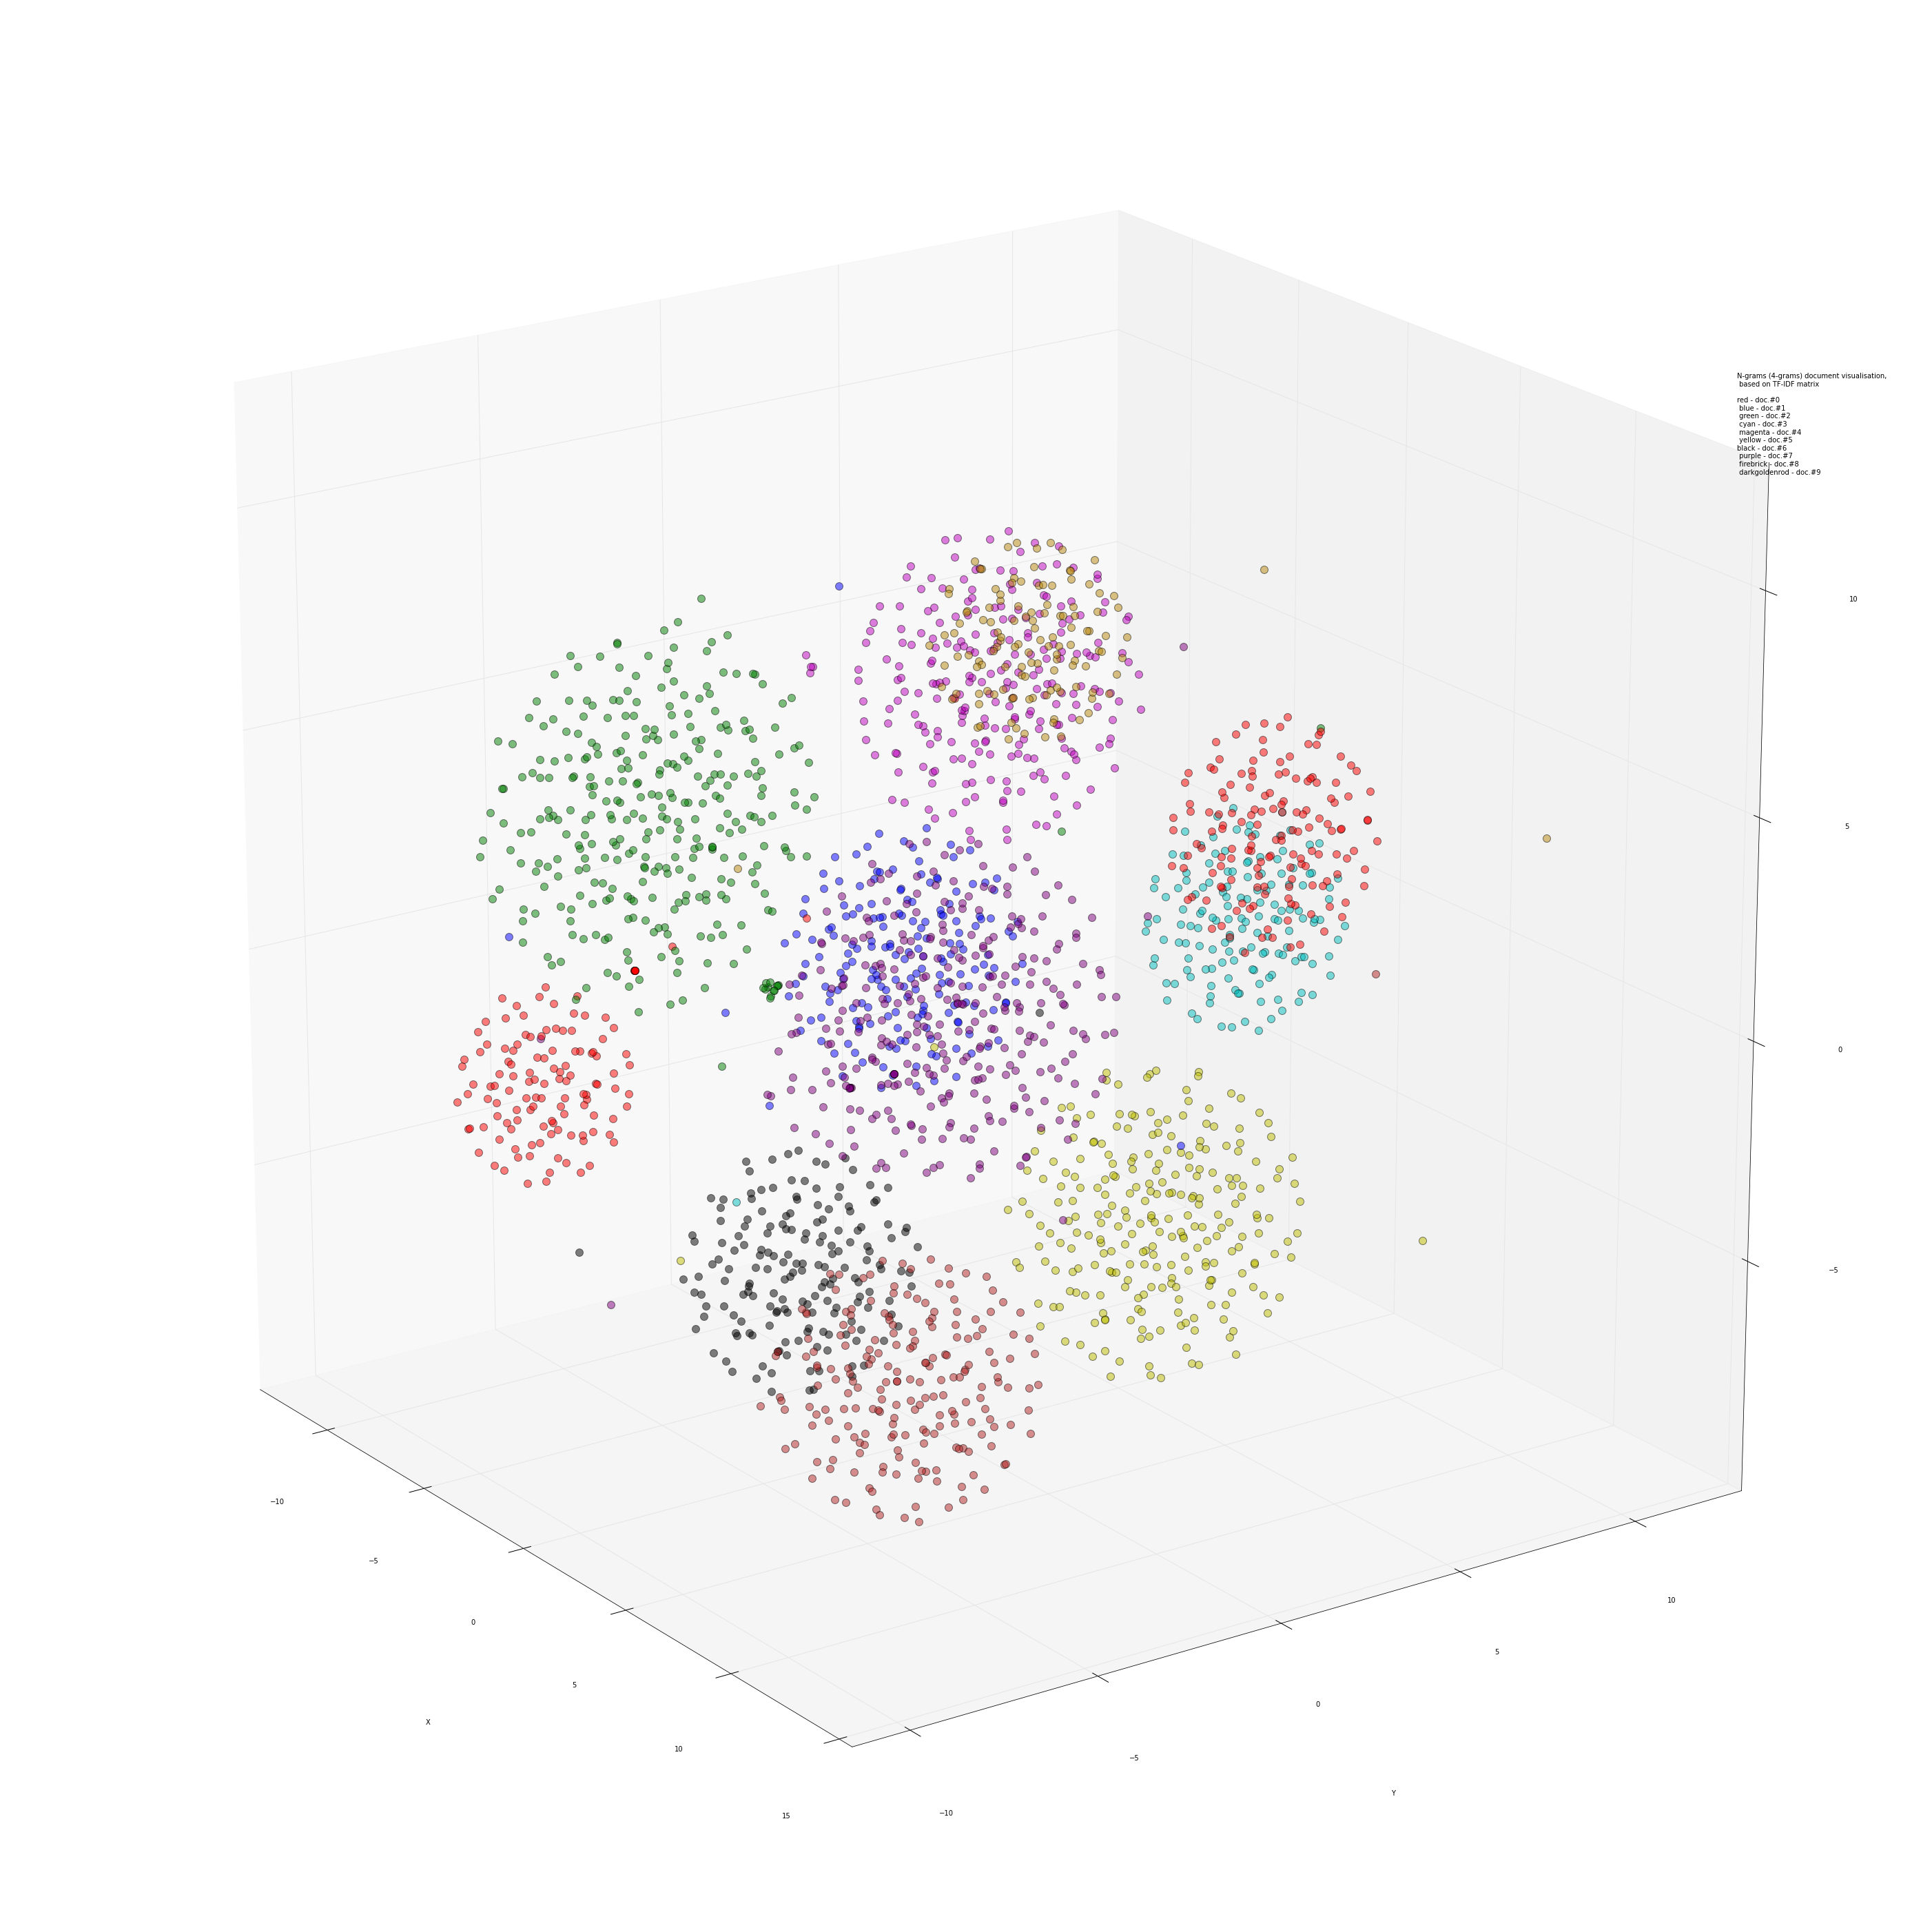

In [47]:
%matplotlib inline

fig = plt.figure(figsize=(50,50))
ax = fig.gca(projection='3d')

N = reduced_matrix.shape

for i in xrange(N[0]):
    xs = reduced_matrix[i,0]
    ys = reduced_matrix[i,1]
    zs = reduced_matrix[i,2]
    
    if i in mappingfeatures[0]:
        color = 'r'
        
    if i in mappingfeatures[1]:
        color = 'b'
        
    if i in mappingfeatures[2]:
        color = 'g'
        
    if i in mappingfeatures[3]:
        color = 'c'
        
    if i in mappingfeatures[4]:
        color = 'm'
        
    if i in mappingfeatures[5]:
        color = 'y'
    
    if i in mappingfeatures[6]:
        color = 'k'
        
    if i in mappingfeatures[7]:
        color = 'purple'
        
    if i in mappingfeatures[8]:
        color = 'firebrick'
        
    if i in mappingfeatures[9]:
        color = 'darkgoldenrod'
    
    s = 120
    marker = 'o'
    label = 'o - means n-gram'        
    ax.scatter(xs, ys, zs, c=color, marker=marker, alpha=0.5, s=s, label=label)



text='N-grams (4-grams) document visualisation,\n based on TF-IDF matrix \n \n'
text1 = 'red - doc.#0\n blue - doc.#1\n green - doc.#2\n cyan - doc.#3\n magenta - doc.#4\n yellow - doc.#5\n'
text2 = 'black - doc.#6\n purple - doc.#7\n firebrick - doc.#8\n darkgoldenrod - doc.#9\n'
ax.text(max(reduced_matrix[:,0]), max(reduced_matrix[:,1]), max(reduced_matrix[:,2]), text+text1+text2, color='black')
ax.set_xlim(min(reduced_matrix[:,0]), max(reduced_matrix[:,0]))
ax.set_ylim(min(reduced_matrix[:,1]), max(reduced_matrix[:,1]))
ax.set_zlim(min(reduced_matrix[:,2]), max(reduced_matrix[:,2]))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=20., azim=-35)

plt.show()